In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Not needed in notebook

In [2]:
# Training settings
# parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
# parser.add_argument('--batch-size', type=int, default=64, metavar='N',
#                     help='input batch size for training (default: 64)')
# parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                     help='input batch size for testing (default: 1000)')
# parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
#                     help='learning rate (default: 0.01)')
# parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
#                     help='SGD momentum (default: 0.5)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='disables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')
# args = parser.parse_args()
# args.cuda = not args.no_cuda and torch.cuda.is_available()

# torch.manual_seed(args.seed)
# if args.cuda:
#     torch.cuda.manual_seed(args.seed)


# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

# Running from the root makes things easy

In [3]:
%cd ../..

/home/kamen/Workspace/Coursework/year4/mlp/mlp-03


In [4]:
from src.datautils.sandia import SandiaDataProvider

# Setup data provider

In [5]:
train_batch_size = 32
test_batch_size = 8

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('datasets/mnist', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=train_batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('datasets/mnist', train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=test_batch_size, shuffle=True)

train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='datasets/sandia/',
                                  img_size=28)
test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
# Reload these every time you start an epoch
train_loader = train_data.get_batch_iterator(train_batch_size)
test_loader = test_data.get_batch_iterator(test_batch_size)

# Define models

In [18]:
lr = 0.1
momentum = 0.5
cuda = True
latent_size = 10

class Autoencoder(nn.Module):
    def __init__(self, latent_size):
        super(Autoencoder, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),  # b, 8, 2, 2
            nn.Conv2d(8, self.latent_size, 2),  # b, latent_size, 1, 1
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.latent_size, 8, 2), # b, 8, 2, 2
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, input_vector):
        latent_vector = self.encoder(input_vector)
        
        # Get reconstruction
        decoded = self.decoder(latent_vector)
        
        # Return reconstruction and latent_vector 
        return decoded, latent_vector

class ReasoningAgent(nn.Module):
    def __init__(self, latent_size):
        super(ReasoningAgent, self).__init__()
        
    def forward(self, latent_vectors):
        # TODO: Implement reasoning agent
        return latent_vectors[:, -1]
    
class Classifier(nn.Module):
    def __init__(self, latent_size):
        super(Classifier, self).__init__()
        self.input_transform = nn.Linear(latent_size, 1)
        self.choice_transform = nn.Linear(latent_size, 1)
    
    def forward(self, latent_prediction, latent_choices):
        # Generate a vector of size num_batch - representing the bias from the prediction
        prediction_bias = self.input_transform(latent_prediction).squeeze()
        # Generate a matrix of size num_batch, num_choices - one value for each choice
        choices_transformed = self.choice_transform(latent_choices).squeeze()
        # Broadcast the bias from the prediction to all choice values
        logits = prediction_bias + choices_transformed.transpose(0, 1)
        # logits is num_choices, num_batches
        return logits.transpose(0, 1)
    
class Architecture(nn.Module):
    def __init__(self, latent_size):
        super(Architecture, self).__init__()
        self.latent_size = latent_size
        self.autoencoder = Autoencoder(self.latent_size)
        self.reasoning_agent = ReasoningAgent(self.latent_size)
        self.classifier = Classifier(self.latent_size)
        
    def forward(self, inputs, choices):
        # inputs and choices are num_batch, im_width, im_height, num_im
        
        transformed_inputs = inputs.permute(0, 3, 1, 2)
        transformed_choices = choices.permute(0, 3, 1, 2)
        # both are num_batch, num_im, im_width, im_height
        num_batch, num_im, im_width, im_height = transformed_inputs.size()
        
        # Reshape for encoder num_im_in_entire_batch, channels(1), im_width, im_height
        transformed_inputs = transformed_inputs.contiguous().view(num_batch * num_im, 1, im_width, im_height)
        transformed_choices = transformed_choices.contiguous().view(num_batch * num_im, 1, im_width, im_height)
        
        # Get reconstructions and latent vectors
        decoded_inputs, latent_inputs = self.autoencoder(transformed_inputs)
        decoded_choices, latent_choices = self.autoencoder(transformed_choices)
        
        # Reshape to regain structure of problem  
        decoded_inputs = decoded_inputs.view(num_batch, num_im, im_width, im_height)
        latent_inputs = latent_inputs.view(num_batch, num_im, self.latent_size)
        decoded_choices = decoded_choices.view(num_batch, num_im, im_width, im_height)
        latent_choices = latent_choices.view(num_batch, num_im, self.latent_size)
        
        # Get latent prediction
        latent_prediction = self.reasoning_agent(latent_inputs)
        
        # Predict label by computing distance between each pair
        logits = self.classifier(latent_prediction, latent_choices)
        
        return logits, latent_prediction, decoded_inputs, decoded_choices
    
model = Architecture(10)
# model = Autoencoder(10)
if cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Train models

In [19]:
log_interval = 50
losses = []
def train_autoencoder_only(epoch):
    model.train()
    # Get new gen object at every epoch
    train_loader = train_data.get_image_batch_iterator(train_batch_size)
    for batch_idx, (data, _) in enumerate(train_loader):
        # Set autoencoder target
        target = data
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        # Ignore latent representations
        output, _ = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if batch_idx % log_interval == 0:
            print('Train Epoch: {0} Loss: {1:.6f}'.format(epoch, loss.data[0]))
            
def train(epoch):
    model.train()
    # Get new gen object at every epoch
    train_loader = train_data.get_batch_iterator(train_batch_size)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = torch.from_numpy(data).float(), torch.from_numpy(target).long()
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        logits, _, _, _ = model(data[:, :, :, :8], data[:, :, :, 8:])
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if batch_idx % log_interval == 0:
            print('Train Epoch: {0} Loss: {1:.6f}'.format(epoch, loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    # Get a fresh generator object
    test_loader = test_data.get_batch_iterator(test_batch_size)
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = torch.from_numpy(data).float(), torch.from_numpy(target).long()
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        logits, _, _, _ = model(data[:, :, :, :8], data[:, :, :, 8:])
        test_loss += F.cross_entropy(logits, target, size_average=False).data[0] # sum up batch loss
        pred = logits.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= test_data.size()
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_data.size(),
        100. * correct / test_data.size()))

epochs = 20
for epoch in range(1, epochs + 1):
    train(epoch)
#     train_autoencoder_only(epoch)
test()

Train Epoch: 1 Loss: 2.077008
Train Epoch: 2 Loss: 2.035835
Train Epoch: 3 Loss: 1.989424
Train Epoch: 4 Loss: 1.913019
Train Epoch: 5 Loss: 1.411404
Train Epoch: 6 Loss: 1.853055
Train Epoch: 7 Loss: 1.599388
Train Epoch: 8 Loss: 1.584521
Train Epoch: 9 Loss: 1.615810
Train Epoch: 10 Loss: 1.536912
Train Epoch: 11 Loss: 1.454510
Train Epoch: 12 Loss: 1.308477
Train Epoch: 13 Loss: 1.387273
Train Epoch: 14 Loss: 1.330840
Train Epoch: 15 Loss: 1.062503
Train Epoch: 16 Loss: 1.331097
Train Epoch: 17 Loss: 1.376385
Train Epoch: 18 Loss: 1.247677
Train Epoch: 19 Loss: 1.166445
Train Epoch: 20 Loss: 1.580148

Test set: Average loss: 2.0863, Accuracy: 30/84 (36%)



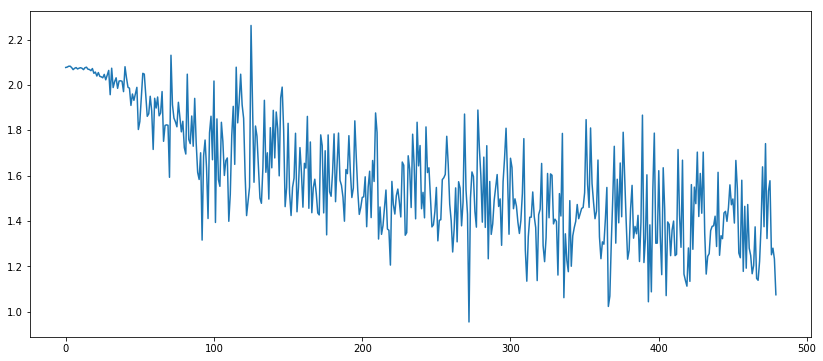

In [20]:
plt.figure(figsize=(14,6))
plt.plot(losses);

In [15]:
data, output = None, None
test_loader = train_data.get_image_batch_iterator(test_batch_size)

for batch_idx, (data, _) in enumerate(test_loader):
    target = data
    if cuda:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output, _ = model(data)
    break

TypeError: forward() missing 1 required positional argument: 'choices'

In [39]:
encoded = model.encoder(data)
eps = Variable(torch.randn(encoded.size())).cuda()
encoded_jittered = encoded + eps * 10

In [40]:
jittered_reconstruction = model.decoder(encoded_jittered)

In [47]:
start, end = data[5, :], data[3, :]
fades = start
for i in range(1, test_batch_size - 1):
    coeff = i / (test_batch_size - 1)
    new = end * coeff + start * (1 - coeff)
    fades = torch.cat((fades, new), 0)
fades = torch.cat((fades, end), 0) 

In [48]:
originals = data.view(test_batch_size, 28, 28).cpu().data.numpy()
reconstructions = output.view(test_batch_size, 28, 28).cpu().data.numpy()
jittered = jittered_reconstruction.view(test_batch_size, 28, 28).cpu().data.numpy()
faded = fades.view(test_batch_size, 28, 28).cpu().data.numpy()

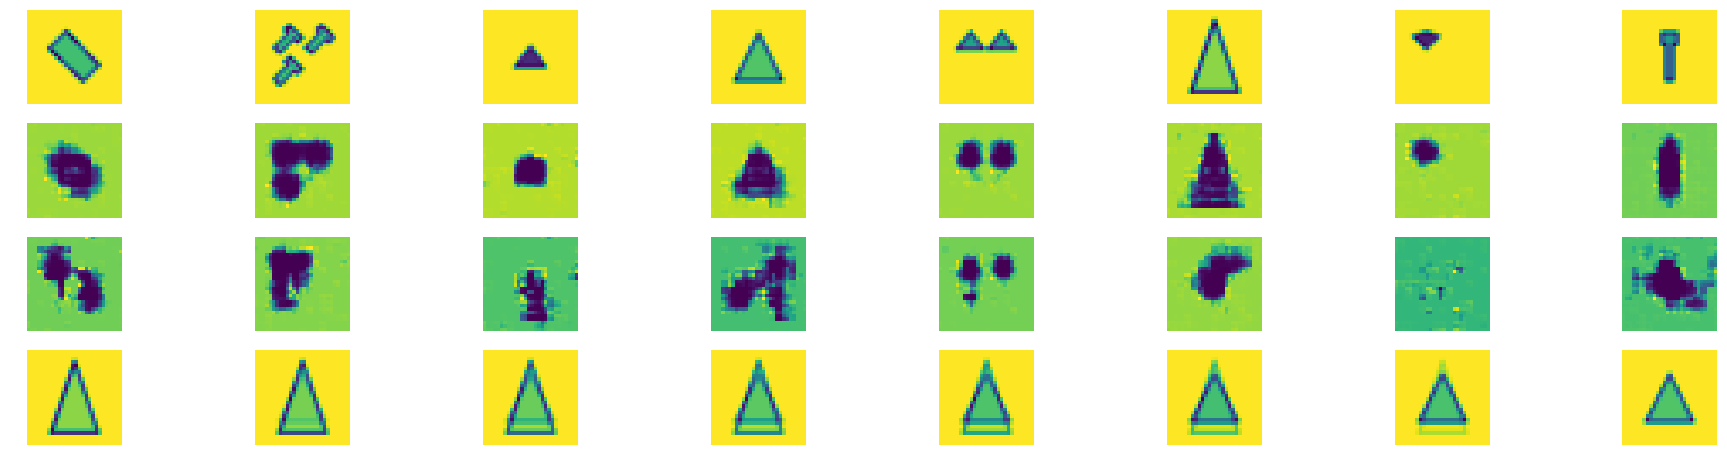

In [49]:
def show_batch_of_images(img_batch, img_size=(1,1), grid_size=None):
    # How many squares for a square grid that can fit all images
    if grid_size == None:
        grid_size = math.ceil(math.sqrt(len(img_batch)))
        grid_size = (grid_size, grid_size)
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(img_size[0] * grid_size[0], img_size[1] * grid_size[1]))
    # Turn the 2d array of axes to a 1d array
    axs = axs.flatten()
    for i, img in enumerate(img_batch):
        axs[i].imshow(img.reshape(28,28))
    # Do this separately in case the number of images we want to show is not a perfect square
    for i in range(grid_size[0] * grid_size[1]):
        axs[i].axis('off')
    plt.show()

show_batch_of_images(np.concatenate([originals, reconstructions, jittered, faded]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))